<div style='background-image: url("title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Spectral Element Method - Elastic Wave Equation 1D - Homogeneous Case</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* The weak form of the 1D elastic wave equation
* Initialization and implementataion of the Mass and Stiffness Matrices
* Solution using the finite difference scheme and its comparion with FEM solution

## Basic Equations

This notebook presents the numerical solution for the 1D elastic wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}

using the spectral element method. This is done after a series of steps summarized as follow:

1) The wave equation is written into its weak form

2) Assume stress-free boundary condition after integration by parts 

3) Approximate the wave field as a linear combination of some basis

\begin{equation}
u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \ \varphi_i(x)
\end{equation}

4) Use the same basis functions in $u(x, t)$ as test functions in the weak form, the so call Galerkin principle.

6) The continuous weak form is written as a system of linear equations by considering the approximated displacement field.

\begin{equation}
\mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f}
\end{equation}

7) Time extrapolation with centered finite differences scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

where $\mathbf{M}$ is known as the mass matrix, and $\mathbf{K}$ the stiffness matrix.

The above solution is exactly the same presented for the classic finite-element method. Now we introduce appropriated basis functions and integration scheme to efficiently solve the system of matrices.

#### Interpolation with Lagrange Polynomials
At the elemental level, we introduce as interpolating functions the Lagrange polynomials and use $\xi$ as the space variable representing our elemental domain:

\begin{equation}
\varphi_i \ \rightarrow \ \ell_i^{(N)} (\xi) \ := \ \prod_{j \neq i}^{N+1} \frac{\xi - \xi_j}{\xi_i-\xi_j}, \qquad   i,j = 1, 2, \dotsc , N + 1  
\end{equation}

#### Numerical Integration
The integral of a continuous function $f(x)$ can be calculated after replacing $f(x)$ by a polynomial approximation that can be integrated analytically. As interpolating functions we use again the Lagrange polynomials and
obtain Gauss-Lobatto-Legendre quadrature. Here, the GLL points are used to perform the integral. 

\begin{equation}
\int_{-1}^1 f(x) \ dx \approx \int _{-1}^1 P_N(x) dx = \sum_{i=1}^{N+1}
 w_i f(x_i) 
\end{equation}





In [12]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

from gll import gll
from lagrange1st import lagrange1st 
from ricker import ricker


### 1. Initialization of setup

In [13]:
# Initialization of setup
# ---------------------------------------------------------------
nt    = 600         # number of time steps
xmax  = 10000.        # Length of domain [m]
vs    = 2500.         # S velocity [m/s]
rho   = 2000          # Density [kg/m^3]
mu    = rho * vs**2   # Shear modulus mu
N     = 6           # Order of Lagrange polynomials
ne    = 125           # Number of elements
Tdom  = .1            # Dominant period of Ricker source wavelet
iplot = 5            # Plotting each iplot snapshot

# variables for elemental matrices
Me = np.zeros(N+1, dtype =  float)
Ke = np.zeros((N+1, N+1), dtype =  float)
# ----------------------------------------------------------------

# Initialization of GLL points integration weights
[xi, w] = gll(N)    # xi, N+1 coordinates [-1 1] of GLL points
                    # w Integration weights at GLL locations
# Space domain
le = xmax/ne        # Length of elements
# Vector with GLL points  
k = 0
xg = np.zeros((N*ne)+1) 
xg[k] = 0
for i in range(1,ne+1):
    for j in range(0,N):
        k = k+1
        xg[k] = (i-1)*le + .5*(xi[j+1]+1)*le

# ---------------------------------------------------------------
dxmin = min(np.diff(xg))  
eps = 0.2           # Courant value
dt = eps*dxmin/vs   # Global time step

# Mapping - Jacobian
J = le/2 
Ji = 1/J    # Inverse Jacobian

# 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)   # Array with GLL as columns for each N+1 polynomial


In [14]:
dt

0.000543283531908528

### 2. The Mass Matrix
Now we initialize the mass and stiffness matrices. In general, the mass matrix at the elemental level is given

\begin{equation}
M_{ji}^e \ = \ w_j  \ \rho (\xi)  \ \frac{\mathrm{d}x}{\mathrm{d}\xi} \delta_{ij} \vert_ {\xi = \xi_j}
\end{equation}


We implement the mass matrix using the integration weights at GLL locations $w$, the jacobian $J$, and density $\rho$. Then, perform the global assembly of the mass matrix, compute its inverse, and display the inverse mass matrix to visually inspect how it looks like.

In [15]:
# Elemental Mass matrix
# ---------------------------------------------------------------
for i in range(0, N+1):
    Me[i] = rho * w[i] * J    #stored as a vector since it's diagonal
                                
# Global Mass matrix
# --------------------------------------------------------------- 
k = -1
ng = (ne-1)*N + N + 1
M = np.zeros(2*ng) 

for i in range(1, ne+1):  
    for j in range(0, N+1): 
        k = k + 1
        if i>1:
            if j==0:
                k = k - 1
        M[k] = M[k] + Me[j]

# Inverse matrix of M 
# --------------------------------------------------------------- 
Minv = np.identity(ng)
for i in range(0,ng):
    Minv[i,i] = 1./M[i]
    
# --------------------------------------------------------------
# Display inverse mass matrix inv(M)
# --------------------------------------------------------------
plt.imshow(Minv)
plt.title('Mass Matrix $\mathbf{M}$')
plt.axis("off")
plt.tight_layout()
plt.show()     

### 3. The Stiffness matrix
On the other hand, the general form of the stiffness matrix at the elemtal level is

\begin{equation}
K_{ji}^e \ = \ \sum_{k = 1}^{N+1} w_k \mu (\xi) \partial_\xi \ell_j (\xi) \partial_\xi \ell_i (\xi) \left(\frac{\mathrm{d}\xi}{\mathrm{d}x} \right)^2 \frac{\mathrm{d}x}{\mathrm{d}\xi} \vert_{\xi = \xi_k}
\end{equation} 

We implement the stiffness matrix using the integration weights at GLL locations $w$, the jacobian $J$, and shear stress $\mu$. Then, perform the global assembly of the mass matrix and display the matrix to visually inspect how it looks like.

In [16]:
# Elemental Stiffness Matrix
# ---------------------------------------------------------------
for i in range(0, N+1):
    for j in range(0, N+1):
        for k in range(0, N+1):
            Ke[i,j] = Ke[i,j] + mu*w[k]*Ji*l1d[i,k]*l1d[j,k]
        
# Global Stiffness Matrix
# --------------------------------------------------------------- 
K = np.zeros([ng, ng])
# Values except at element boundaries 
for k in range(1,ne+1):
    i0 = (k-1)*N + 1
    j0 = i0
    for i in range(-1,N):
        for j in range(-1,N):
            K[i0+i,j0+j] = Ke[i+1,j+1]
            
# Values at element boundaries 
for k in range(2,ne+1):
    i0 = (k - 1)*N
    j0 = i0
    K[i0,j0] = Ke[0,0] + Ke[N,N]
       

# --------------------------------------------------------------
# Display stiffness matrix K
# --------------------------------------------------------------
plt.imshow(K)
plt.title('Stiffness Matrix $\mathbf{K}$')
plt.axis("off")

plt.tight_layout()
plt.show()

### 4. Spectral Element solution 

Finally we implement the spectral element solution using the computed mass $M$ and stiffness $K$ matrices together with a finite differences extrapolation scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

<IPython.core.display.Javascript object>


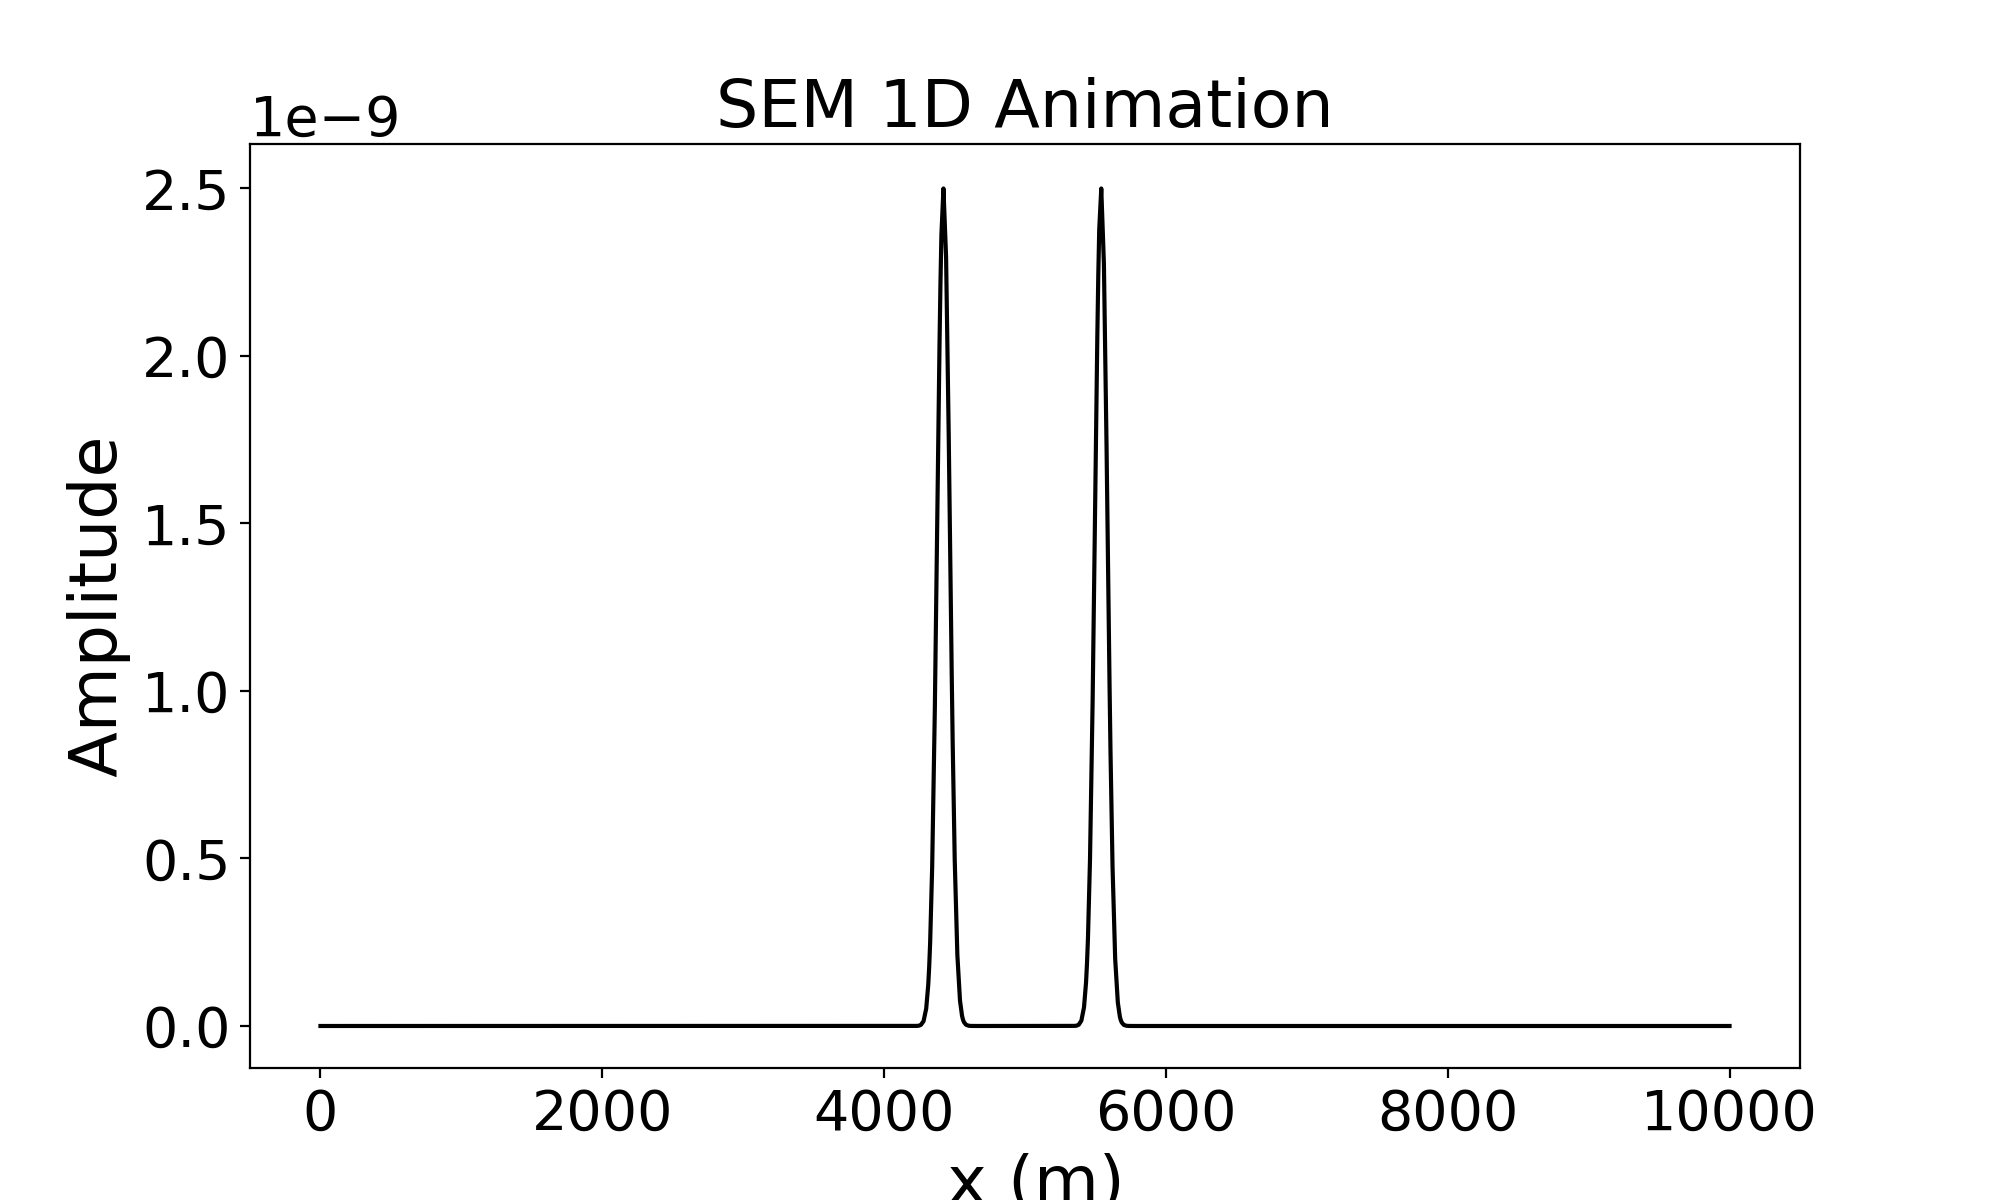

In [17]:
# SE Solution, Time extrapolation
# ---------------------------------------------------------------

# initialize source time function and force vector f
src  = ricker(dt,Tdom)
isrc = int(np.floor(ng/2))   # Source location

# Initialization of solution vectors
u = np.zeros(ng)
uold = u
unew = u
f = u 

# --------------------------------------------------------------
# Initialize animated plot
# --------------------------------------------------------------
plt.figure(figsize=(10,6))
lines = plt.plot(xg, u, lw=1.5)
plt.title('SEM 1D Animation', size=24)
plt.xlabel(' x (m)', size=24)
plt.ylabel(' Amplitude ', size=24)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.ion() # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt): 
    # Source initialization
    f= np.zeros(ng)
    if it < len(src):
        f[isrc-1] = src[it-1] 
               
    # Time extrapolation
    unew = dt**2 * Minv @ (f - K @ u) + 2 * u - uold
    uold, u = u, unew

    # --------------------------------------   
    # Animation plot. Display solution 
    if not it % iplot:
        for l in lines:
            l.remove()
            del l
        # -------------------------------------- 
        # Display lines            
        lines = plt.plot(xg, u, color="black", lw = 1.5)
        plt.gcf().canvas.draw()       